<a href="https://colab.research.google.com/github/dohyeon-kim012/MachineLearning-DeepLearning/blob/main/DeepLearning/19.CNN-Residual%20Network%20%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet의 구조
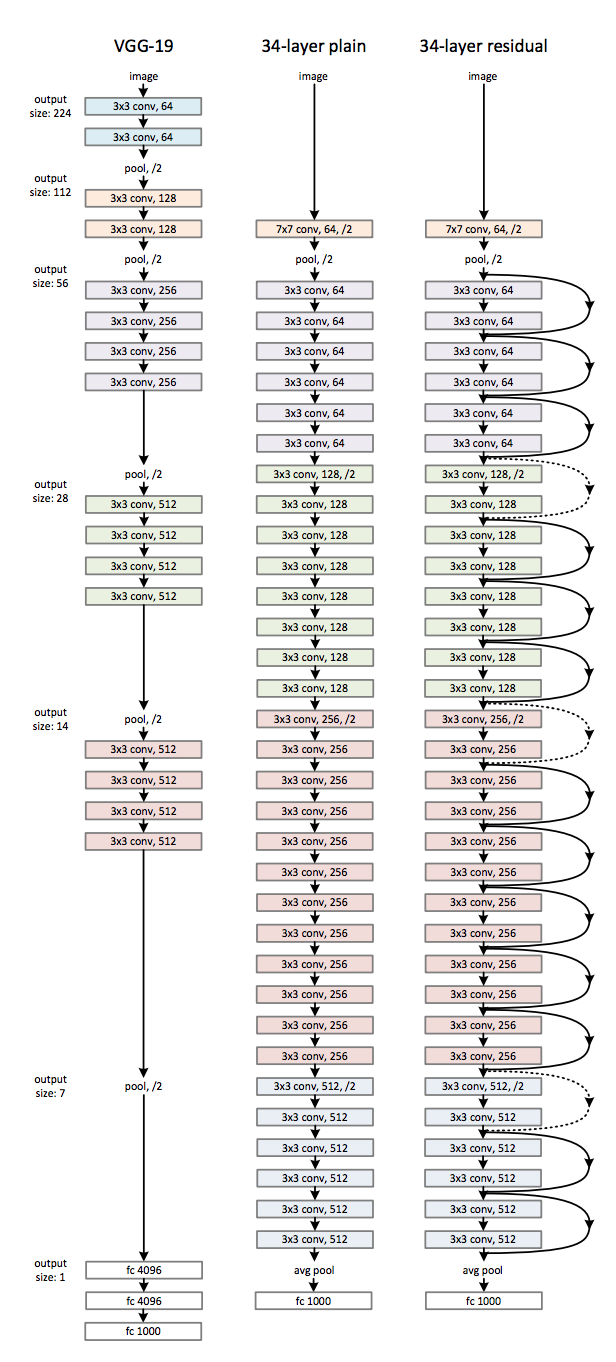

## Skip Connection

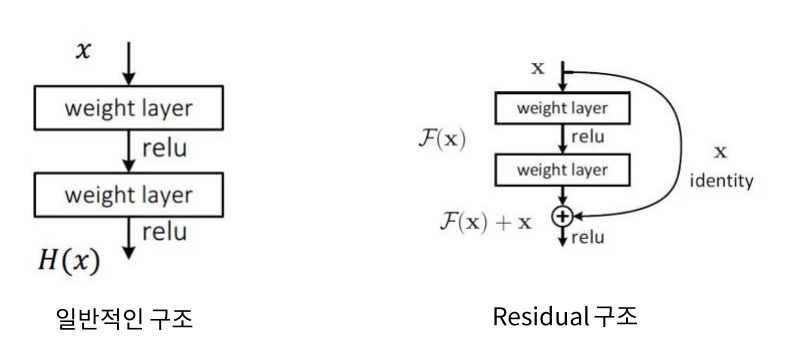

* 왼쪽의 Weight Layer (Convolution) - relu - Weight Layer (Convolution) - relu 가 일반적인 구조
* 오른쪽의 입력을 출력쪽으로 더해주는 구조가 Residual 구조
  * 입력을 identity라 한다

## Identity Mapping
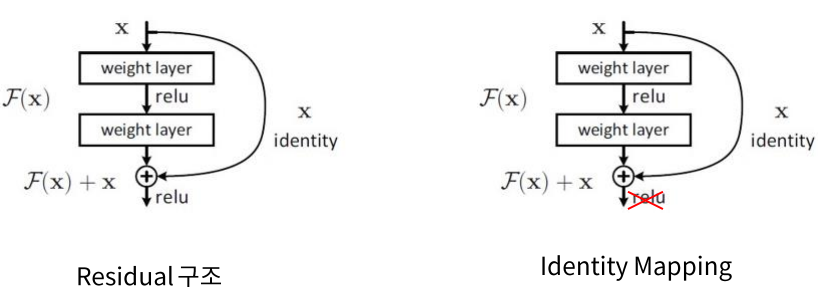


Residual 구조에서 발전된 형태로 Identity Mapping이라는 형식이 새로 추가되었다.

Residual 구조에서 feature를 뽑고 더해주고 난 다음 **relu**를 적용하지 않는 것이 특징이다.

## Pre Activation
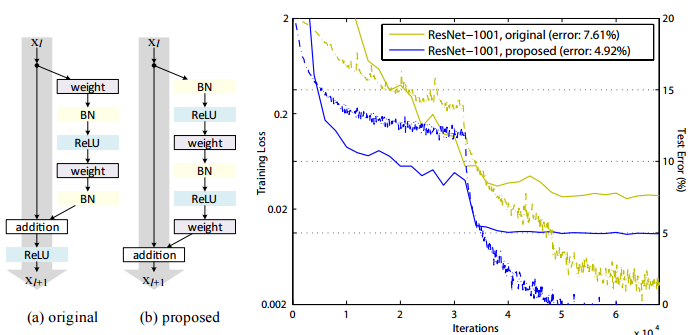

왼쪽이 기본 `Residual` 구조, 오른쪽이 `Identity Mapping`을 하기 위한 `Pre Activation` 구조이다.

기존에서는 `weight-bn-relu-weight-bn` 후 더하고 `relu`로 출력을 내는 것이 Residual Unit 이었는데

새롭게 바뀐 방식에서는 `bn-relu-weight`구조로 굉장히 독특해 진다. `conv` 레이어를 통과하기 전에 relu를 통과하기 때문에 pre activation구조라 한다. 

`pre activation` 구조 제안을 이용해 `conv` 레이어 두번이 통과된 다음에 `identity`와 이어져서 입력이 그대로 출력과 이어지게 해 `gradient highway`를 구성하도록 하였다.

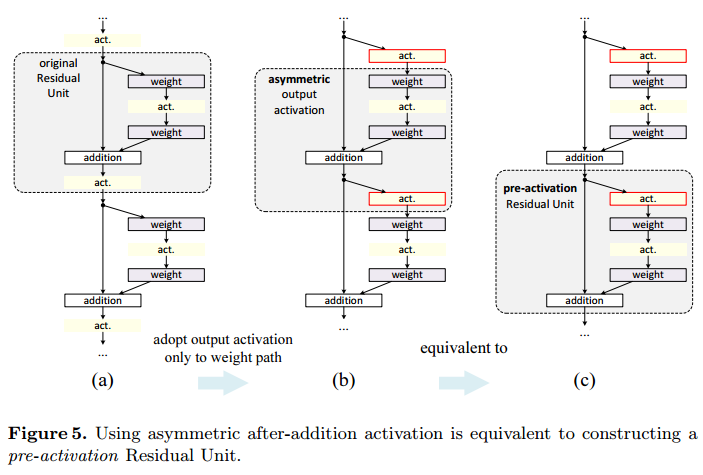

제일 좌측이 기존 구조, 가운데와 오른쪽은 `pre-activation` 구조이다. 이 경우에는 `asymmetric` 하다라고 표현하는데, 기존 `activation`을 `conv`구조 다음에 한다고 봤을 때는 `conv-act-conv-덧셈-activation` 식으로 덧셈이 중간에 들어가기 때문에 비대칭 형태로 설명이 가능하다. 이것을 시작점으로 다르게 보면 preactivation 형태로 나타나게 되는 것이다.

In [ ]:
import tensorflow as tf
import numpy as np

# Residual Network 구현

## Residual Unit 구현

* `bn-relu-conv-bn-relu-addition` 까지만 하는 하나의 Residual 작업 단위

In [ ]:
class ResidualUnit(tf.keras.Model):
  # filter_in : 입력 데이터의 필터 개수
  # filter_out : 유닛에서 내보낼 필터의 개수
  def __init__(self, filter_in, filter_out, kernel_size):
    super(ResidualUnit, self).__init__()

    # ReLU 레어어는 학습 가능한 파라미터가 없으니까 그냥 사용할 때(call)만 구성해 줘도 된다.
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')

    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')

    # C_in(filter_in)과 C_out(filter_out)의 개수가 다르면 identity mapping이 되지 않기 때문에
    # filter_in과 filter_out이 같으면 identity 레이어는 단순하게 x를 리턴
    if filter_in == filter_out:
      self.identity = lambda x: x
    else:
      # filter_in과 filter_out이 다르면 강제로 (filter_out, 1x1 형태)의 conv 레이어를 만들어 준다.
      # 입력 데이터 x의 채널을 filter_out에 맞게 변경
      self.identity = tf.keras.layers.Conv2D(filter_out, (1, 1), padding='same')
  
  def call(self, x, training=False):
    # training이 무엇보다 중요하다!!!
    #  BN은 훈련 때와 추론 때가 작동해야 하는 방식이 다르기 때문에 BN을 쓴다면 반드시 훈련 여부를 확인해 줘야 한다.
    h = self.bn1(x, training=training) # 추론 과정에서는 False, 훈련 과정에서는 True
    h = tf.nn.relu(h) # tf.nn은 함수
    h = self.conv1(h)

    h = self.bn2(h, training=training)
    h = tf.nn.relu(h) 
    h = self.conv2(h)

    return self.identity(x) + h

1) 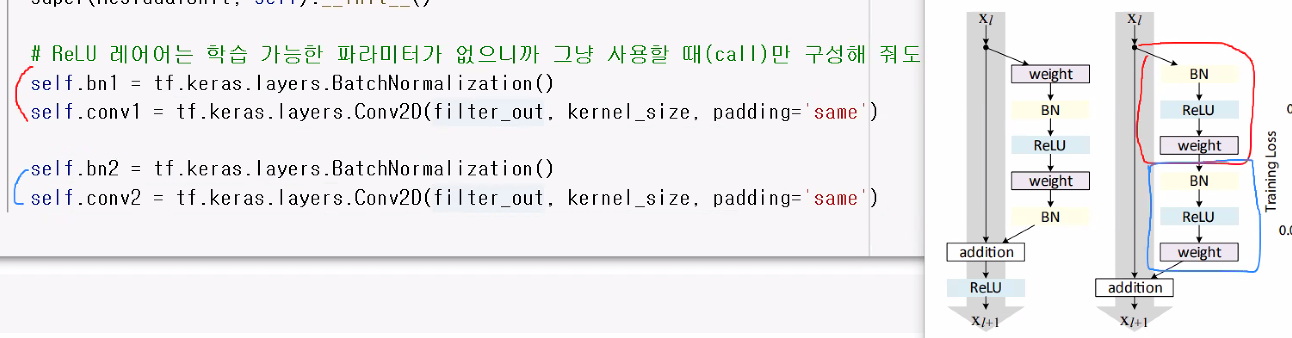

2) identity 구현을 위한 함수 정의  
1. `filter_in` 의 채널 수 = `filter_out` 의 채널 수  
    --> addition ( 더하기 ) 에 문제가 없기 때문에 `identity` 레이어는 단순하게 `x`를 리턴함

2. `filter_in` 의 채널 수 != `filter_out` 의 채널 수  
    --> `identity mapping` ( 더하기 ) 가 안 됨  
    --> 강제로 ( filter_out, 1*1 형태 ) 의 conv 레이어를 만들어 줘야 한다  
    --> 입력 데이터 x의 채널을 filter_out에 맞게 변경해야 함

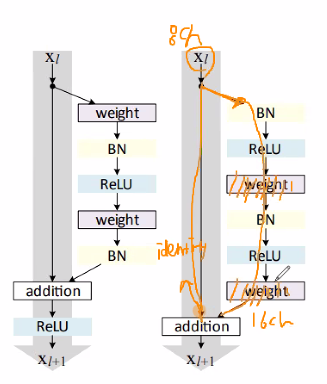

## Residual Layer
Residual Unit을 이용해 Feature Extraction을 하는 부분

In [ ]:
class ResnetLayer(tf.keras.Model):

    # filter_in : 입력(x)되는 필터 개수
    # filters : Resnet 레이어는 Residual Unit이 여러 개가 이
    #       filters의 값만큼 unit들이 묶일 것임
  def __init__(self, filter_in, filters, kernel_size):
    super(ResnetLayer, self).__init__()
    # 유닛들을 filters에 들어있는 필터의 개수만큼 묶어줄 리스트
    self.sequence = list()

    # zip([filter_in] + list(filters), filters)
    # ex) [16] + [32, 32, 32]
    #     zip([16, 32, 32, 32], [32, 32, 32])
    #    1) 16, 32
    #    2) 32, 32
    #    3) 32, 32
    for f_in, f_out in zip([filter_in] + list(filters), filters):
      self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

  def call(self, x, training=False):
    for unit in self.sequence:
      x = unit(x, training=False) # unit의 call이 호출 될 것임.
    return x    

```python
zip([filter_in] + list(filters), filters)

ex) [16] + [32, 32, 32]
zip([16, 32, 32, 32], [32, 32, 32])
 1) 16, 32
 2) 32, 32
 3) 32, 32
```

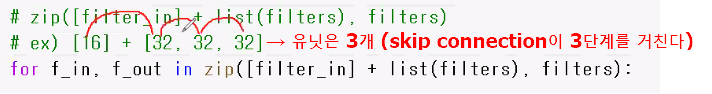

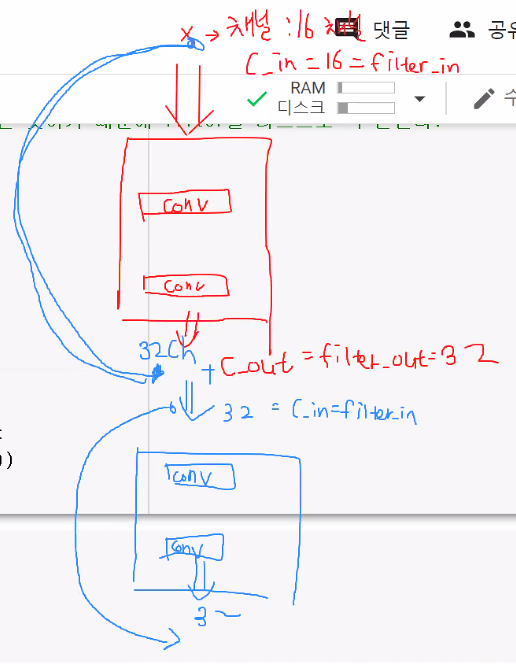

## 모델 정의

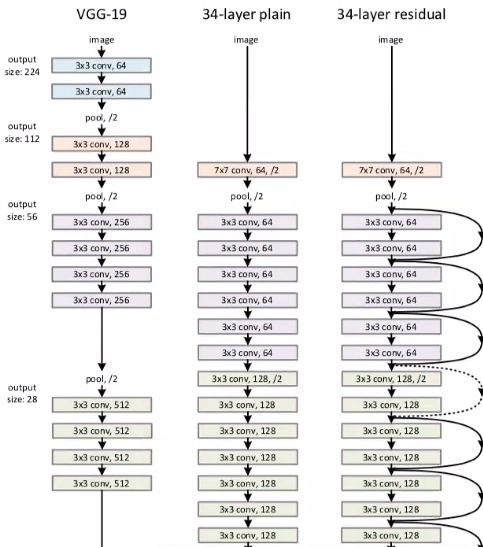

In [ ]:
# class MyModel
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()

        ############ Feature Extraction ####################

        # 반드시 제일 처음에 Convolution을 이용해 초기 Feature를 뽑고,
        # 그 Feature를 기점으로 ResNet을 돌리는 것이 효과가 좋다.
        self.conv1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')
        # -> Mnist 기준으로 Output은 그대로 유지되서 (28, 28, 8)

        # conv1의 output의 채널이 8채널 이니까 ResnetLayer의 filter_in도 8이 된다.
        self.res1 = ResnetLayer(8, (16, 16), kernel_size=(3, 3)) # output : ( 28, 28, 16 )
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # output : ( 14, 14, 16 )
    
        self.res2 = ResnetLayer(16, (32, 32), (3, 3)) # output : (14, 14, 32)
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # output : ( 7, 7, 32 )

        self.res3 = ResnetLayer(32, (64, 64), (3, 3)) # output : (7, 7, 64)

        ################ Fully Connected #####################

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        
    # training 변수를 잊지 말고 넣어줘야 함
    def call(self, x, training=False):
        x = self.conv1(x)

        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

```ResnetLayer(8, (16, 16), (3, 3))```

--> 8채널로 들어와서 ( 16, 16 ) 의 두 개의 유닛을 쓴다는 의미

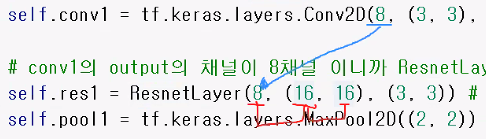

## 데이터셋 준비

In [ ]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.

X_train.shape, X_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

## 학습 ( training ), 테스트 ( inference ) 루프 함수로 정의

In [ ]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    
    with tf.GradientTape() as tape:
        # !!! 중요 !!!
        #       훈련 과정이기 때문에 BN의 training = True
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

# inference 단계 --> training = False
# 추론 과정에서는 BN 에 대한 학습이 있으면 안 되기 때문에
@tf.function
def test_step(model, images, labels, loss_object, optimizer, test_loss, test_accuracy):
    predictions = model(images, training=False)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 학습 환경 정의

모델 생성, loss, optimizer, metrics 정의

In [ ]:
# 모델 생성
model = ResNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer   = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### 학습 루프 동작

In [ ]:
for epoch in range(10):

    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_image, test_labels in test_ds:
        test_step(model, images, labels, loss_object, optimizer, test_loss, test_accuracy)

    print("Epoch : {}, Train Loss : {:.5f}, Train Acc : {:.5f}, Test Loss : {:.5f}, Test Acc : {:.5f}".format(
        epoch+1,
        train_loss.result(),
        train_accuracy.result() * 100,

        test_loss.result(),
        test_accuracy.result() * 100
  ))

  # loss, accuracy 평가를 1에폭마다 초기화 하면서 보기
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch : 1, Train Loss : 0.11000, Train Acc : 96.63834, Test Loss : 0.58822, Test Acc : 96.87500
Epoch : 2, Train Loss : 0.04486, Train Acc : 98.59833, Test Loss : 0.00285, Test Acc : 100.00000
Epoch : 3, Train Loss : 0.03462, Train Acc : 98.95000, Test Loss : 0.00162, Test Acc : 100.00000
Epoch : 4, Train Loss : 0.02793, Train Acc : 99.11000, Test Loss : 0.00453, Test Acc : 100.00000
Epoch : 5, Train Loss : 0.02644, Train Acc : 99.18667, Test Loss : 0.58670, Test Acc : 96.87500
Epoch : 6, Train Loss : 0.02128, Train Acc : 99.34666, Test Loss : 0.00007, Test Acc : 100.00000
Epoch : 7, Train Loss : 0.01916, Train Acc : 99.46667, Test Loss : 0.00007, Test Acc : 100.00000
Epoch : 8, Train Loss : 0.01875, Train Acc : 99.42833, Test Loss : 0.00057, Test Acc : 100.00000
Epoch : 9, Train Loss : 0.01833, Train Acc : 99.44833, Test Loss : 0.00442, Test Acc : 100.00000
Epoch : 10, Train Loss : 0.01625, Train Acc : 99.52167, Test Loss : 0.00026, Test Acc : 100.00000
